In [1]:
import tensorflow as tf

print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
# Import requirement libraries and tools
from tensorflow import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Dropout, Input, ReLU, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [3]:
img_width, img_height = 256, 256
batchsize = 32

# Membuat instance ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Memuat dataset
train = datagen.flow_from_directory(
    directory=r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\dataset\original\kencur',
    target_size=(img_width, img_height),
    batch_size=batchsize,
    class_mode=None  # Tidak menghasilkan label
)

Found 500 images belonging to 1 classes.


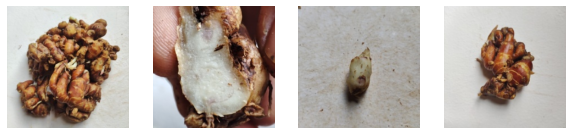

In [4]:
# Mengambil batch gambar dari DirectoryIterator
batch = next(train)  # Mengambil batch pertama

# Membuat subplot untuk menampilkan gambar
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))

# Menampilkan 4 gambar pertama dari batch
for idx, img in enumerate(batch[:4]):
    ax[idx].imshow(img)  # Menampilkan gambar
    ax[idx].axis('off')  # Menyembunyikan sumbu

plt.show()

In [5]:
# Generating Augmented Batches of Images using ImageDataGenerator
DIR = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\dataset\original\kencur' #path

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
        DIR,
        target_size = (64, 64),
        batch_size = batchsize,
        class_mode = None)

#train_generator[0]

Found 500 images belonging to 1 classes.


In [6]:
# Creating the Generator Model 

KI = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_dim = 300

def Generator_Model():

    Generator = Sequential()

    # Random noise
    Generator.add(Dense(8 * 8 * 512, input_dim=input_dim))
    Generator.add(ReLU())
    # Convert 1d to 3d
    Generator.add(Reshape((8, 8, 512)))
    # Unsample
    Generator.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2D(3, (4, 4), padding='same', activation='sigmoid'))

    return Generator
    
generator = Generator_Model()
generator.summary()
# Visualized Layers of generator
keras.utils.plot_model(generator, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             9863168   
_________________________________________________________________
re_lu (ReLU)                 (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       2097408   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       524416    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 64)        131136    
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         3

In [7]:
# Creating the Discriminator Model 

def Discriminator_Model():
    input_shape = (64, 64, 3)

    # Create a Sequential model
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=(3, 3), activation=LeakyReLU(), input_shape=input_shape))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(128, kernel_size=(3, 3), activation=LeakyReLU()))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(256, kernel_size=(3, 3), activation=LeakyReLU()))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Flatten())
    discriminator.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator

# Training The CNN
discriminator = Discriminator_Model()
discriminator.summary()  
# Visualized Layers of discriminator
keras.utils.plot_model(discriminator, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)             

In [8]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim=input_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def call(self, inputs):
        # Generate images from random noise
        random_noise = tf.random.normal(shape=(tf.shape(inputs)[0], self.latent_dim))
        generated_images = self.generator(random_noise, training=True)
        return generated_images

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [9]:
# DCGAN Monitor for Image Generation and Model Saving

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim = input_dim):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs = None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 255) + 255
        g_img.numpy()
        
    def on_train_end(self, logs = None):
        self.model.generator.save('DCGAN-kencur.h5')

In [10]:
# Training DCGAN on Image Dataset

epochs = 130
lr_g =0.0003
lr_d = 0.0001
beta = 0.5
latent_dim = 300

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim )
dcgan.compile(g_optimizer = Adam (learning_rate= lr_g, beta_1= beta), d_optimizer= Adam (learning_rate = lr_g , beta_1= beta), loss_fn = BinaryCrossentropy())

# Fit the model and save the history
history = dcgan.fit(train_generator, epochs=epochs, callbacks=[DCGANMonitor()])

Epoch 1/130
16/16 [==============================] - 8s 528ms/step - d_loss: 0.5419 - g_loss: 1.0197
Epoch 2/130
16/16 [==============================] - 4s 276ms/step - d_loss: 0.3533 - g_loss: 1.1972
Epoch 3/130
16/16 [==============================] - 4s 275ms/step - d_loss: 0.4478 - g_loss: 1.2337
Epoch 4/130
16/16 [==============================] - 5s 284ms/step - d_loss: 0.3007 - g_loss: 1.6440
Epoch 5/130
16/16 [==============================] - 4s 274ms/step - d_loss: 0.1797 - g_loss: 2.6309
Epoch 6/130
16/16 [==============================] - 4s 271ms/step - d_loss: 0.3063 - g_loss: 2.0406
Epoch 7/130
16/16 [==============================] - 4s 277ms/step - d_loss: 0.0592 - g_loss: 2.5187
Epoch 8/130
16/16 [==============================] - 5s 287ms/step - d_loss: 0.5592 - g_loss: 1.8435
Epoch 9/130
16/16 [==============================] - 4s 266ms/step - d_loss: 0.4104 - g_loss: 1.4541
Epoch 10/130
16/16 [==============================] - 4s 271ms/step - d_loss: 0.5691 - g_lo

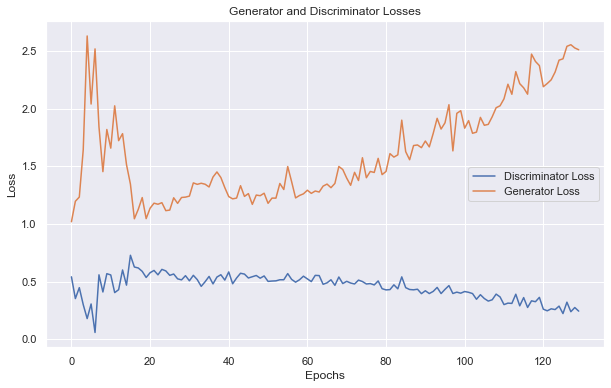

In [11]:
# Function to create a figure for the losses
def create_loss_figure(d_loss_values, g_loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label='Discriminator Loss')
    plt.plot(g_loss_values, label='Generator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Access the loss values from the history
d_loss_values = history.history['d_loss']
g_loss_values = history.history['g_loss']

# Call the create_loss_figure function with the loss values
create_loss_figure(d_loss_values, g_loss_values)

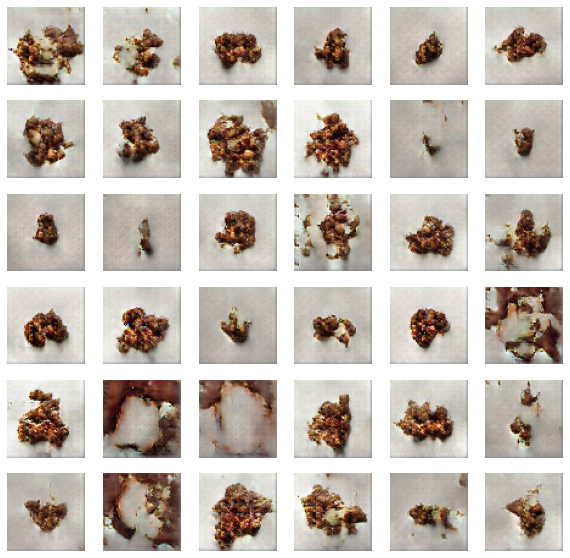

In [12]:
# Generating 36 Random Images with DCGAN

plt.figure(figsize=(10, 10))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    # Generate random noise for each image
    noise = tf.random.normal([1, 300])
    mg = dcgan.generator(noise)
    # Denormalize
    mg = (mg * 255) + 255

    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

In [ ]:
# Generate Images After Training Phase

import os
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the path to save the generated images
save_dir = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\generated_images\DCGAN-kencur'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Function to convert a generated image to a hash
def image_to_hash(image):
    return hash(image.tobytes())

# Set to store unique images
unique_images = set()

# Number of images to generate
num_images = 500

# Counter for the number of unique images generated
unique_count = 0

# Loop until we have 500 unique images
while unique_count < num_images:
    # Generate random noise
    noise = tf.random.normal([1, input_dim])
    
    # Generate an image from the noise
    generated_image = generator(noise, training=False)
    
    # Denormalize the image (update this line)
    generated_image = (generated_image * 255)  # Change this line
    generated_image = np.array(generated_image[0], dtype=np.uint8)
    
    # Convert the image to a hash
    image_hash = image_to_hash(Image.fromarray(generated_image))
    
    # Check if the image is unique
    if image_hash not in unique_images:
        unique_images.add(image_hash)
        
        # Save the image
        image_path = os.path.join(save_dir, f'image_{unique_count}.png')
        Image.fromarray(generated_image).save(image_path)
        
        # Increment the unique image counter
        unique_count += 1

    # Print progress
    if unique_count % 50 == 0:
        print(f'Generated {unique_count} unique images so far.')

print(f'Finished generating {num_images} unique images.')

# Define the path to the generated images
save_dir = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\generated_images\DCGAN-kencur'

# List all image files in the directory
image_files = [f for f in os.listdir(save_dir) if f.endswith('.png')]

# Number of images to display
num_images_to_display = 25

# Ensure we don't try to display more images than we have
if num_images_to_display > len(image_files):
    num_images_to_display = len(image_files)

# Create a figure to display the images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

# Load and display the images
for i in range(num_images_to_display):
    image_path = os.path.join(save_dir, image_files[i])
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels

# Hide any unused subplots
for i in range(num_images_to_display, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Generated 50 unique images so far.
Generated 100 unique images so far.
Generated 150 unique images so far.
Generated 200 unique images so far.
Generated 250 unique images so far.
Generated 300 unique images so far.
Generated 350 unique images so far.
Generated 400 unique images so far.
Generated 450 unique images so far.
Generated 500 unique images so far.
Finished generating 500 unique images.


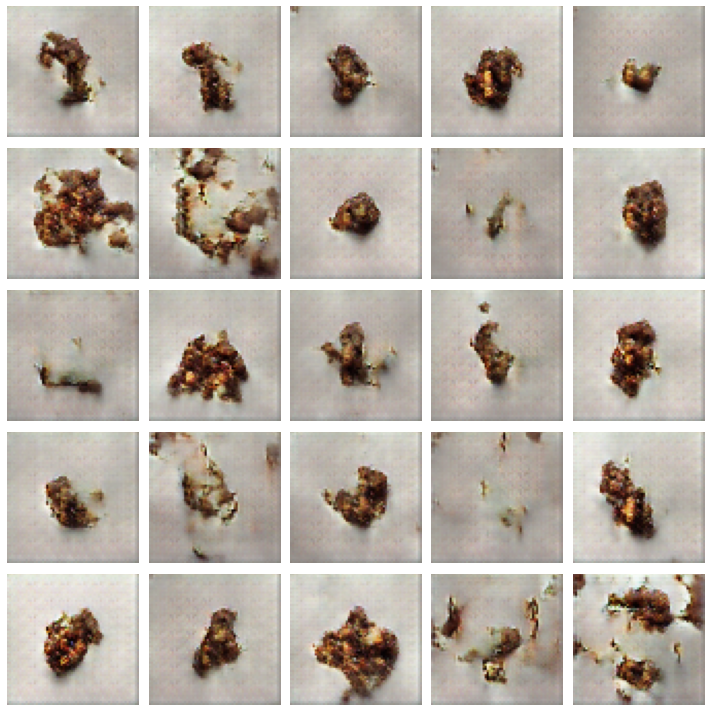

In [1]:
# Generate Image from Saved Model (.h5)

import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the path to the saved generator model
model_path = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\DCGAN-kencur.h5'

# Load the pre-trained generator model
generator = tf.keras.models.load_model(model_path)

# Define the path to save the generated images
save_dir = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\generated_images\DCGAN-kencur'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Function to convert a generated image to a hash
def image_to_hash(image):
    return hash(image.tobytes())

# Set to store unique images
unique_images = set()

# Number of images to generate
num_images = 500

# Counter for the number of unique images generated
unique_count = 0

# Loop until we have 500 unique images
while unique_count < num_images:
    # Generate random noise
    noise = tf.random.normal([1, 300])
    
    # Generate an image from the noise
    generated_image = generator(noise, training=False)
    
    # Denormalize the image (update this line)
    generated_image = (generated_image * 255)  # Change this line
    generated_image = np.array(generated_image[0], dtype=np.uint8)
    
    # Convert the image to a hash
    image_hash = image_to_hash(Image.fromarray(generated_image))
    
    # Check if the image is unique
    if image_hash not in unique_images:
        unique_images.add(image_hash)
        
        # Save the image
        image_path = os.path.join(save_dir, f'image_{unique_count}.png')
        Image.fromarray(generated_image).save(image_path)
        
        # Increment the unique image counter
        unique_count += 1

    # Print progress
    if unique_count % 50 == 0:
        print(f'Generated {unique_count} unique images so far.')

print(f'Finished generating {num_images} unique images.')

# Define the path to the generated images
save_dir = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\generated_images\DCGAN-kencur'

# List all image files in the directory
image_files = [f for f in os.listdir(save_dir) if f.endswith('.png')]

# Number of images to display
num_images_to_display = 25

# Ensure we don't try to display more images than we have
if num_images_to_display > len(image_files):
    num_images_to_display = len(image_files)

# Create a figure to display the images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

# Load and display the images
for i in range(num_images_to_display):
    image_path = os.path.join(save_dir, image_files[i])
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels

# Hide any unused subplots
for i in range(num_images_to_display, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()